In [9]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import pickle
from EvaluationLog import AttentionScoresLog
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '/home/wdwatson2/projects/CAT-Transformer/model')
from testingModel import CATTransformer, MyFTTransformer, Combined_Dataset, train, test, EarlyStopping

device_in_use = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device_in_use)

cuda


In [3]:
df_train = pd.read_csv('/home/wdwatson2/projects/CAT-Transformer/datasets/helena/train.csv')
df_test = pd.read_csv('/home/wdwatson2/projects/CAT-Transformer/datasets/helena/test.csv')
df_val = pd.read_csv('/home/wdwatson2/projects/CAT-Transformer/datasets/helena/validation.csv')

cont_columns = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27']
target = ['class']

#CHECKING TO MAKE SURE YOUR LIST IS CORRECT (NO NEED TO TOUCH)
yourlist = cont_columns + target
yourlist.sort()
oglist = list(df_train.columns)
oglist.sort()

assert(yourlist == oglist), "You may of spelled feature name wrong or you forgot to put one of them in the list"

target_classes = [max(len(df_train[target].value_counts()), len(df_val[target].value_counts()),len(df_test[target].value_counts()))]
print("target classes",target_classes)
# Create a StandardScaler and fit it to the cont features
scaler = StandardScaler()
scaler.fit(df_train[cont_columns])

# Transform the training, test, and validation datasets
df_train[cont_columns] = scaler.transform(df_train[cont_columns])
df_test[cont_columns] = scaler.transform(df_test[cont_columns])
df_val[cont_columns] = scaler.transform(df_val[cont_columns])

#Wrapping in Dataset
train_dataset = Combined_Dataset(df_train, cat_columns=[], num_columns=cont_columns, task1_column='class')
val_dataset = Combined_Dataset(df_val, cat_columns=[], num_columns=cont_columns, task1_column='class')
test_dataset = Combined_Dataset(df_test, cat_columns=[], num_columns=cont_columns, task1_column='class')

#This is a hyperparameter that is not tuned. Maybe mess with what makes sense here
batch_size = 256

# Wrapping with DataLoader for easy batch extraction
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


target classes [100]


In [4]:
attention_log = AttentionScoresLog()

models = ["CAT", "FT"]
num_layers = [1,2,5]
datasets = ["Helena"]

for model in models:
    for layer in num_layers:
        attention_log.add_model_layers(model, layer)

attention_log.add_new_dataset('Helena')

In [6]:
model = CATTransformer(n_cont=len(cont_columns),
                       cat_feat=[],
                       targets_classes=target_classes,
                       get_attn=True,
                       num_layers=2).to(device_in_use)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.0001)

early_stopping = EarlyStopping(patience=5, verbose=True)

train_losses = []
train_accuracies_1 = [] 
test_losses = []
test_accuracies_1 = [] 

train_attns = []
test_attns = []

epochs = 200

for t in range(epochs):
    train_loss, train_acc, train_attn = train(regression_on=False, 
                                  get_attn=True,
                                   dataloader=train_dataloader, 
                                   model=model, 
                                   loss_function=loss_function, 
                                   optimizer=optimizer, 
                                   device_in_use=device_in_use)
    test_loss, test_acc, test_attn = test(regression_on=False,
                               get_attn=True,
                               dataloader=test_dataloader,
                               model=model,
                               loss_function=loss_function,
                               device_in_use=device_in_use)
    train_losses.append(train_loss)
    train_accuracies_1.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies_1.append(test_acc)
    train_attns.append(train_attn)
    test_attns.append(test_attn)

    epoch_str = f"Epoch [{t+1:2}/{epochs}]"
    train_metrics = f"Train: Loss {(train_loss)}, Accuracy {(train_acc)}"
    test_metrics = f"Test: Loss {(test_loss)}, Accuracy {(test_acc)}"
    print(f"{epoch_str:15} | {train_metrics:65} | {test_metrics:65}")

    early_stopping(test_acc, model)
    
    if early_stopping.early_stop:
        print("Early stopping")
        break


attention_log.add_attention_scores('CAT', 2, 'Helena', train_attns, test_attns)


Epoch [ 1/200]  | Train: Loss 4.207978147368191, Accuracy 0.07967219580603457       | Test: Loss 3.797031365908109, Accuracy 0.12822085889570553       
Validation score improved. Saving model...
Epoch [ 2/200]  | Train: Loss 3.624476166410819, Accuracy 0.18932006924206235       | Test: Loss 3.3311954950674987, Accuracy 0.2492842535787321       
Validation score improved. Saving model...
Epoch [ 3/200]  | Train: Loss 3.290412350073873, Accuracy 0.2517255735477792        | Test: Loss 3.1259028911590576, Accuracy 0.27505112474437626      
Validation score improved. Saving model...
Epoch [ 4/200]  | Train: Loss 3.128614636106864, Accuracy 0.27773517102351164       | Test: Loss 2.996133254124568, Accuracy 0.3014314928425358        
Validation score improved. Saving model...
Epoch [ 5/200]  | Train: Loss 3.0383199406735724, Accuracy 0.29434450117229444      | Test: Loss 2.9308312856234036, Accuracy 0.31022494887525565      
Validation score improved. Saving model...
Epoch [ 6/200]  | Train: 

In [7]:
train_scores, test_scores = attention_log.get_attention_scores('CAT', 2, 'Helena')

test = np.array(train_scores).squeeze(0)
test.shape
avg_test = test.mean(1)
avg_test.shape

(60, 2, 27)

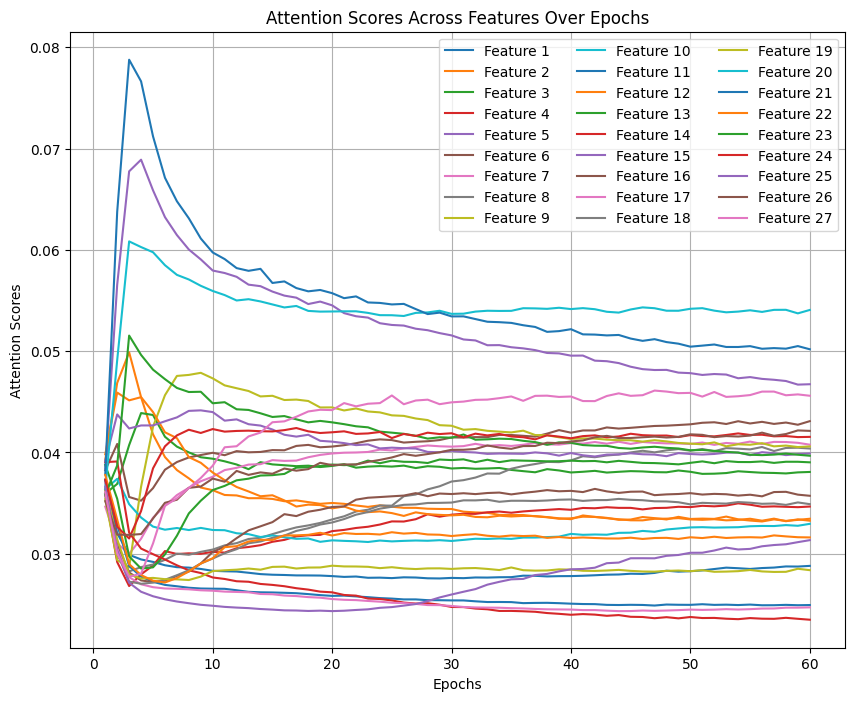

In [8]:
avg_test = avg_test.mean(1)
epochs = range(1, avg_test.shape[0]+1)  
num_features = avg_test.shape[1]

plt.figure(figsize=(10, 8))

# Plotting all features for the current layer
for feature_idx in range(num_features):
    plt.plot(epochs, avg_test[:, feature_idx], label=f'Feature {feature_idx + 1}')

plt.title(f'Attention Scores Across Features Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Attention Scores')
plt.legend(ncol=3) 
plt.grid(True)
plt.show()

In [10]:
df_val

,class,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27
0,20,-0.132413,1.224684,-0.643093,-0.353591,1.050304,0.962274,-0.637671,0.044445,0.450338,...,0.060653,-0.400858,0.036853,-0.134338,0.947487,0.228881,0.802479,0.145913,-1.000173,0.960863
1,31,-0.909187,-1.443013,-1.021269,0.118154,0.320656,-1.328490,-0.969857,3.626077,0.488786,...,0.425634,-1.054108,0.678549,-0.634983,1.432727,0.577545,0.499732,0.545497,0.257480,-0.767683
2,86,0.012123,0.684861,-0.359462,0.711697,-1.525953,0.663090,-0.402588,-0.516308,-0.028328,...,0.466964,-2.313390,-0.507891,-1.009367,2.990506,1.547768,1.981064,0.443719,0.002785,-0.273389
3,45,1.589081,1.265906,0.606027,0.083465,1.022703,1.236159,0.568385,-0.934767,-0.848056,...,0.193427,-0.152122,-0.760575,0.249333,0.576834,0.007959,0.481839,0.122664,-0.891240,0.467854
4,3,-0.883183,-1.172122,-1.296306,0.385960,-0.055664,-1.105937,-1.238904,1.350894,-0.287923,...,0.269895,0.080996,-0.268244,2.181317,0.344753,1.021793,1.554837,0.284034,0.075748,0.060647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9774,34,-0.858006,-1.333086,-0.823586,1.148088,0.974811,-1.231468,-0.757613,1.143178,-0.727525,...,0.323944,-1.045925,1.612100,1.321143,2.366048,1.833186,1.639652,0.379346,0.058140,0.145752
9775,45,0.724505,-0.100331,1.259241,1.322010,-0.683073,-0.214238,1.347728,-0.850199,-0.776519,...,0.636040,-0.871628,-1.771524,1.143860,1.269167,0.426940,1.803985,0.428598,-0.477258,0.213486
9776,86,-0.671048,-0.689228,-0.425359,-1.282585,-1.382174,-0.758162,-0.673888,-0.174086,0.955996,...,0.484894,-0.009263,-0.681600,0.089458,-0.234081,-0.067533,0.080784,0.521056,-0.761899,0.182727
9777,57,-0.578103,-0.889452,-0.539954,-1.749778,-1.458226,-0.785864,-0.417172,-0.432531,-1.790576,...,0.479434,-1.247356,0.387111,1.655976,2.172129,0.733504,4.861595,0.128773,0.244015,-0.276526


In [11]:
df_val['class'].value_counts()

class
76    574
35    480
51    457
33    385
32    343
     ... 
2      15
27     15
37     14
26     13
52      9
Name: count, Length: 100, dtype: int64

In [25]:
sample_class76 = df_val.loc[df_val['class'] == 76]

sample_class76.shape
sample_class76 = sample_class76.sample(n=5)
input_class76 = sample_class76.drop('class', axis=1)
target_class76 = sample_class76['class']

In [26]:
#Now lets take model in evaluation mode and run certain samples through
#it

class_76_dataset = Combined_Dataset(sample_class76, cat_columns=[], num_columns=cont_columns, task1_column='class')

# Create a mini-dataloader
batch_size = 5  # Adjust batch size as needed
sample_dataloader = DataLoader(class_76_dataset, batch_size=batch_size)

# Define your evaluation function
def evaluate(model, dataloader, loss_function, device_in_use):
    model.eval()  # Set model to evaluation mode
    loss_vals = []
    accuracies = []
    attentions = []

    with torch.no_grad():
        for (cat_x, cont_x, labels) in dataloader:
            cat_x,cont_x,labels=cat_x.to(device_in_use),cont_x.to(device_in_use),labels.to(device_in_use)

            predictions, attention = model(cat_x, cont_x)

            loss = loss_function(predictions, labels.long())
            loss_vals.append(loss.item())

            _, predicted = torch.max(predictions, 1)
            accuracy = (predicted == labels).sum().item() / labels.size(0)
            accuracies.append(accuracy)

            attentions.append(attention.cpu().numpy())  # Assuming attn is a tensor of attention scores

    avg_loss = np.mean(loss_vals)
    avg_accuracy = np.mean(accuracies)
    all_attentions = np.concatenate(attentions, axis=0) if attentions else None

    return avg_loss, avg_accuracy, all_attentions

# Evaluate the model on the mini-dataloader
loss_function = torch.nn.CrossEntropyLoss()  # Define your loss function

sample_loss, sample_accuracy, sample_attentions = evaluate(model, sample_dataloader, loss_function, device_in_use)

print(f"Sample: Loss {sample_loss}, Accuracy {sample_accuracy}")

Sample: Loss 0.16848018765449524, Accuracy 1.0


In [27]:
sample_attentions_76 = sample_attentions.mean(0)
sample_attentions_76

array([0.02802115, 0.0274628 , 0.03267611, 0.03068127, 0.04572092,
       0.03953793, 0.03549665, 0.03614364, 0.0365823 , 0.02969354,
       0.02642446, 0.042057  , 0.04034668, 0.03035562, 0.04726632,
       0.02920677, 0.02530598, 0.04001927, 0.02441187, 0.06032556,
       0.05290604, 0.03118183, 0.03699483, 0.03966577, 0.026852  ,
       0.05171297, 0.05295075], dtype=float32)

In [51]:
sample_class26 = df_val.loc[df_val['class'] == 26]

sample_class26.shape
sample_class26 = sample_class26.sample(n=5)
input_class26 = sample_class26.drop('class', axis=1)
target_class26 = sample_class26['class']

class_26_dataset = Combined_Dataset(sample_class26, cat_columns=[], num_columns=cont_columns, task1_column='class')

# Create a mini-dataloader
batch_size = 5  # Adjust batch size as needed
sample_dataloader = DataLoader(class_26_dataset, batch_size=batch_size)

# Evaluate the model on the mini-dataloader
loss_function = torch.nn.CrossEntropyLoss()  # Define your loss function

sample_loss, sample_accuracy, sample_attentions = evaluate(model, sample_dataloader, loss_function, device_in_use)

print(f"Sample: Loss {sample_loss}, Accuracy {sample_accuracy}")

Sample: Loss 2.5295803546905518, Accuracy 0.4


In [52]:
sample_attentions_26 = sample_attentions.mean(0)
sample_attentions_26

array([0.02776549, 0.03278992, 0.03813566, 0.03214085, 0.04390023,
       0.04074055, 0.0375447 , 0.03782156, 0.03754054, 0.03941303,
       0.02452861, 0.03251807, 0.0332775 , 0.02102539, 0.03471551,
       0.04186962, 0.02349412, 0.03344506, 0.02608908, 0.05307089,
       0.05400796, 0.03104897, 0.05503674, 0.05386293, 0.03280687,
       0.03911762, 0.04229259], dtype=float32)

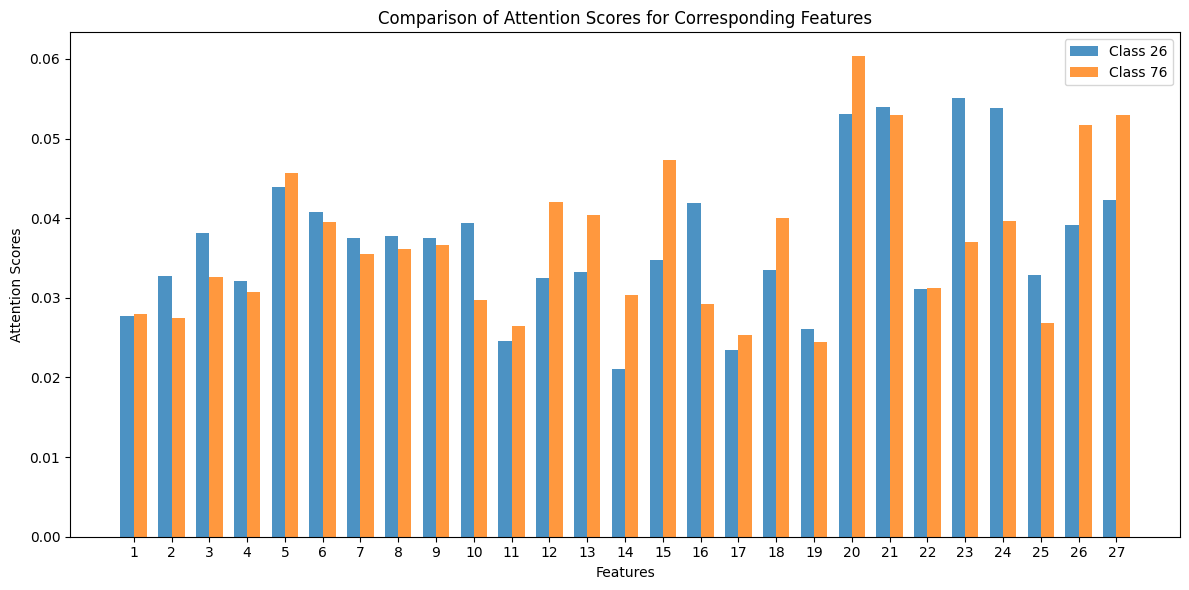

In [56]:
dist1 = sample_attentions_26
dist2 = sample_attentions_76

# Creating feature indices for x-axis ticks (assuming 27 features)
features = np.arange(1, 28)

# Plotting bar plots for comparison
plt.figure(figsize=(12, 6))

# Offset for bar width
bar_width = 0.35
index = np.arange(len(features))

# Plotting bars for each class
plt.bar(index, dist1, bar_width, label='Class 26', alpha=0.8)
plt.bar(index + bar_width, dist2, bar_width, label='Class 76', alpha=0.8)

plt.xlabel('Features')
plt.ylabel('Attention Scores')
plt.title('Comparison of Attention Scores for Corresponding Features')
plt.xticks(index + bar_width / 2, features)
plt.legend()
plt.tight_layout()
plt.show()